In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures,LabelEncoder
import matplotlib.pyplot as plt
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression

#Allowed models
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, ElasticNet, Lars, Lasso, LassoLars

In [2]:
#Load data in pandas dataframe
np.set_printoptions(threshold=sys.maxsize)
PATH = "data.csv"
df = pd.read_csv(PATH)
train_df = df[df["price"].notna()].copy()
test_df =  df[df["price"].isna()].copy()
train_df.head()

,carat,depth,table,x,y,z,cut,color,clarity,price
40000,0.36,69.5,61.3,4.585,4.521,2.842,P,H,VS1,714.0
40001,0.87,70.7,56.3,6.686,6.737,4.188,I,G,VS2,7504.0
40002,0.54,67.2,65.8,6.153,6.177,3.747,V,D,SI2,1368.0
40003,0.30,69.6,69.8,5.146,5.110,3.099,P,D,VS2,923.0
40004,0.60,68.6,49.4,4.884,4.910,2.961,P,E,SI1,2873.0


In [3]:
for col in df.columns:
    print(col, df[col].dtype)

carat float64
depth float64
table float64
x float64
y float64
z float64
cut object
color object
clarity object
price float64


<h2>Data Analsye </h2>

In [4]:
df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.642,4.693,2.867,I,G,VS1,NaN
1,1.64,67.3,60.7,7.843,7.821,4.940,V,E,SI1,NaN
2,0.25,67.3,49.5,4.005,4.041,2.493,I,F,VVS1,NaN
3,0.28,67.9,60.3,4.299,4.258,2.661,P,E,VS2,NaN
4,0.34,67.5,69.4,5.439,5.497,3.321,P,E,VS2,NaN
...,...,...,...,...,...,...,...,...,...,...
199995,1.02,68.7,50.2,5.686,5.582,3.471,P,E,VVS1,12445.0
199996,0.65,68.7,55.1,5.117,5.135,3.132,G,G,VVS2,3191.0
199997,0.34,67.5,61.5,5.048,5.103,3.007,I,H,VVS2,722.0
199998,0.48,68.7,53.0,4.469,4.451,2.722,I,G,IF,1474.0


<p>No missing data found</p>

In [5]:
for col in df.columns:
    missing = sum(df[col].isnull())
    if missing != 0:
        print(col,":",missing, df[col].dtype)

price : 40000 float64


<p>Review data</p>

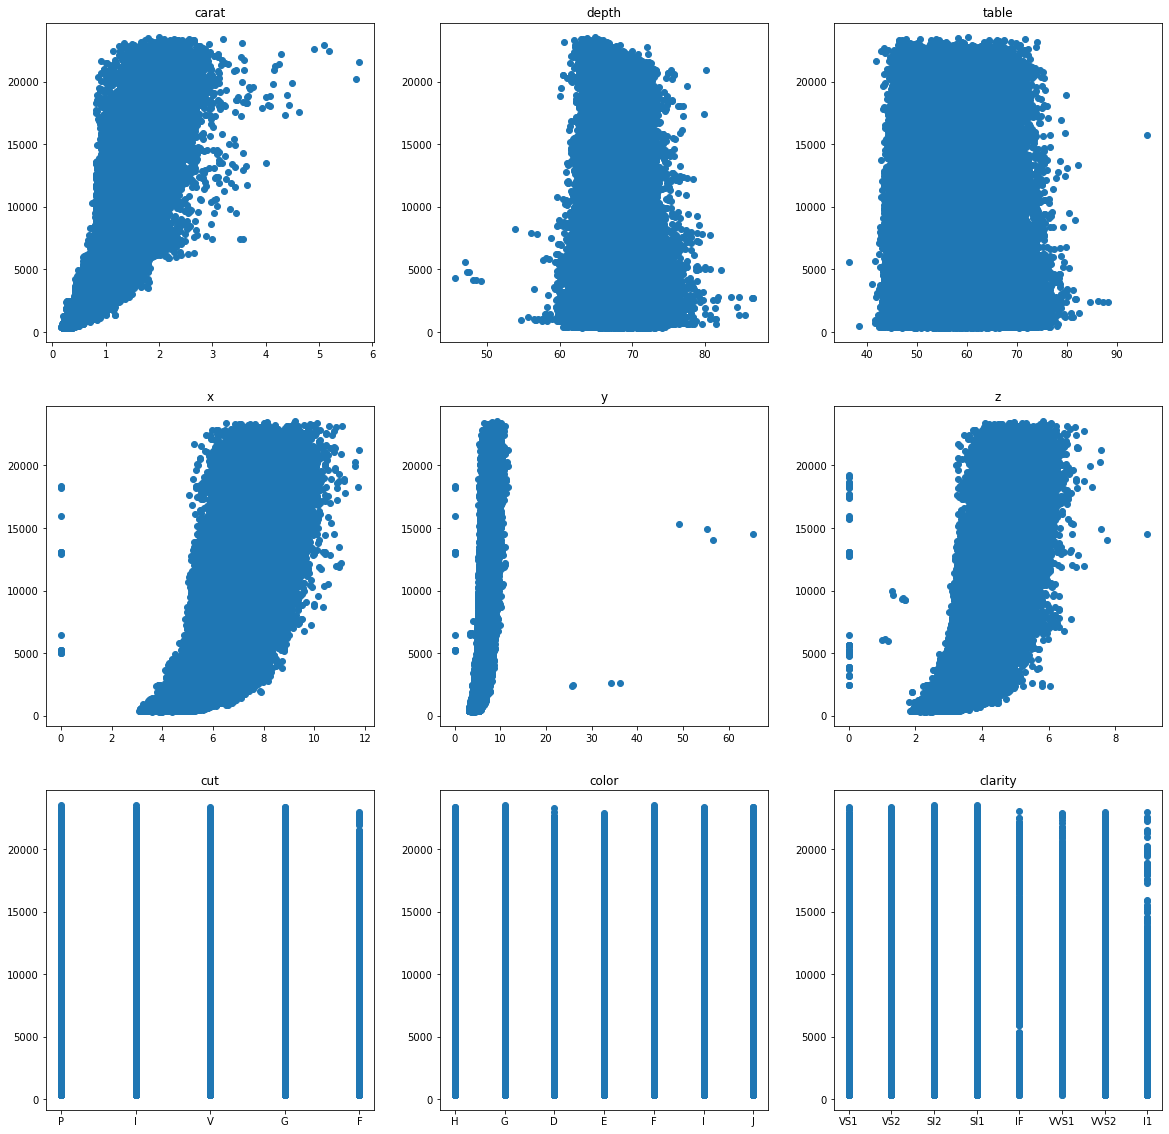

In [6]:
fig, axs = plt.subplots(3,3, figsize=(20,20))
for i, col in enumerate(train_df.columns):
    if col != "price":
        axs[i//3][i%3].title.set_text(col)
        axs[i//3][i%3].scatter(train_df[col],train_df["price"])

<h3>Data manipulation</h3>

In [7]:
#Remove outliers
for col in train_df.columns:
    if train_df[col].dtype == "float64":
        idx = []
        mean = train_df[col].mean()
        std = train_df[col].std()
        indexs = train_df[((((train_df[col]-mean)**2)**0.5/std)>3)].index
        train_df = train_df.drop(indexs)

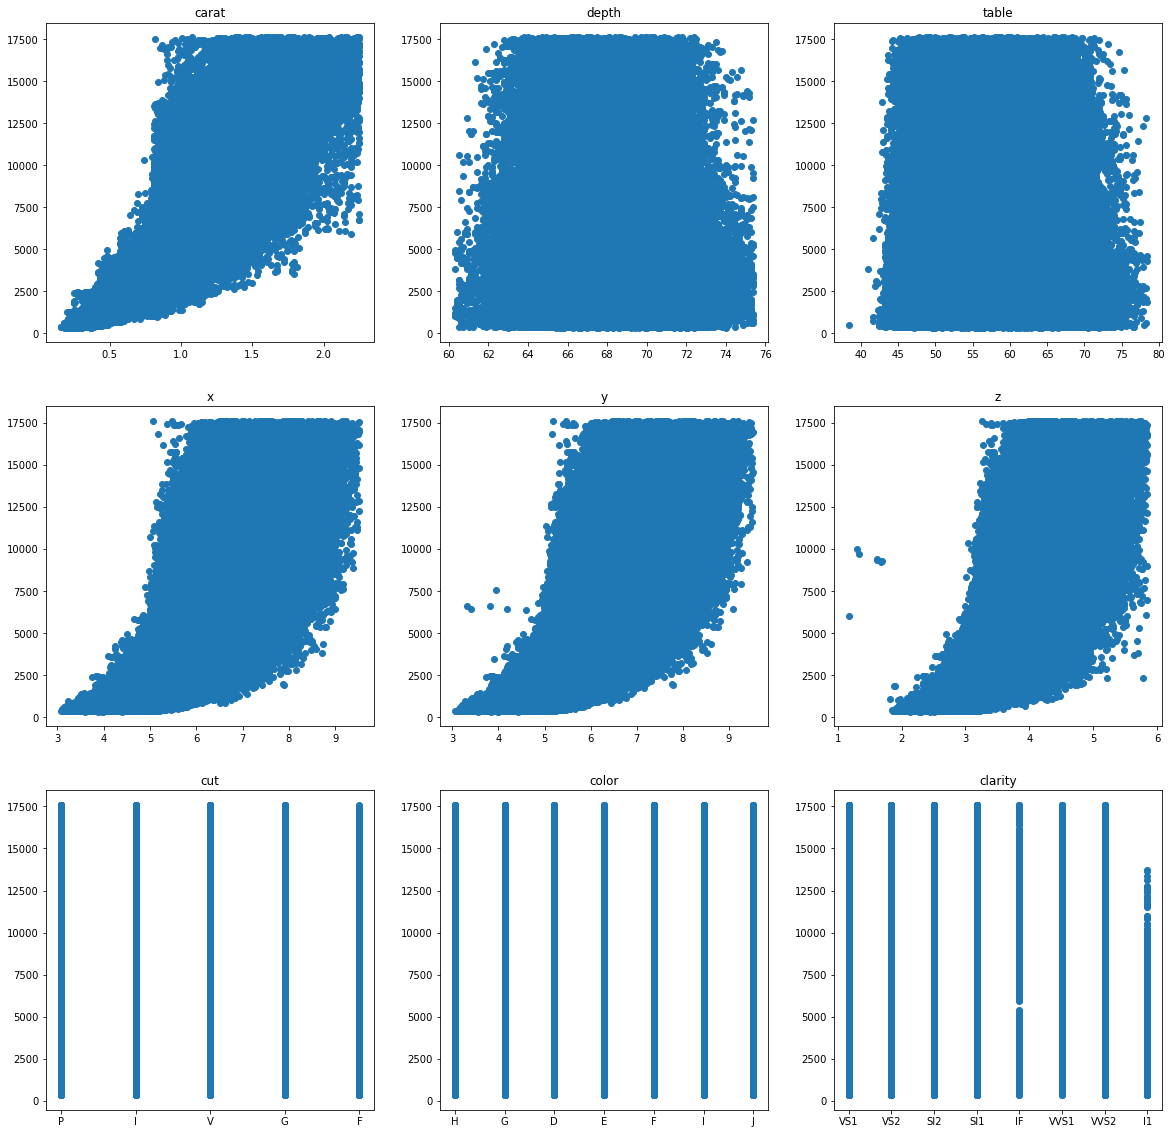

In [8]:
fig, axs = plt.subplots(3,3, figsize=(20,20))
for i, col in enumerate(train_df.columns):
    if col != "price":
        axs[i//3][i%3].title.set_text(col)
        axs[i//3][i%3].scatter(train_df[col],train_df["price"])

float64
float64
float64
float64
float64
float64
object
object
object
float64


<AxesSubplot:xlabel='price', ylabel='Count'>

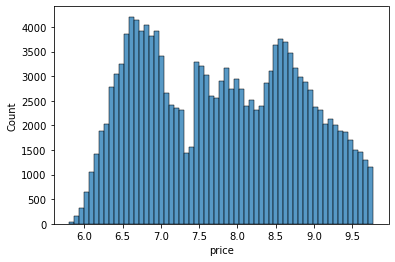

In [9]:
df = pd.concat([train_df,test_df])

for col in df.columns:
    print(df[col].dtype)
    if df[col].dtype == "float64":
        df[col] = np.log1p(df[col])
sns.histplot(df["price"])

<h3>Feature generation</h3>

In [10]:
color_ref = (df["price"]/df["carat"]).groupby(df["color"], dropna=False).mean()
clarity_ref = (df["price"]/df["carat"]).groupby(df["clarity"], dropna=False).mean()
cut_ref = (df["price"]/df["carat"]).groupby(df["cut"], dropna=False).mean()
print(color_ref,clarity_ref,cut_ref)

color
D    18.072509
E    18.180564
F    17.182339
G    17.023910
H    15.758349
I    14.773749
J    13.255856
dtype: float64 clarity
I1      11.565766
IF      21.732643
SI1     15.483588
SI2     13.445668
VS1     17.578121
VS2     17.068776
VVS1    21.336000
VVS2    19.755985
dtype: float64 cut
F    13.303443
G    15.614625
I    17.961942
P    15.974327
V    16.597417
dtype: float64


In [11]:
df["color/cost"] = df.apply(lambda row: color_ref[row.color] , axis=1)
df["clarity/cost"] = df.apply(lambda row: clarity_ref[row.clarity] , axis=1)
df["cut/cost"] = df.apply(lambda row: cut_ref[row.cut] , axis=1)

In [12]:
df = pd.get_dummies(df)

In [13]:
train_df = df[df["price"].notna()]
test_df =  df[df["price"].isna()]

In [14]:
X = train_df.drop(["price"], axis=1)
y = train_df["price"]

poly = PolynomialFeatures(degree = 2)
X = poly.fit_transform(X)
X = pd.DataFrame(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#baseline
Linear_pipe = Pipeline([("scaler",StandardScaler()),("linear",LinearRegression())])

534.3871835834507


<AxesSubplot:xlabel='price'>

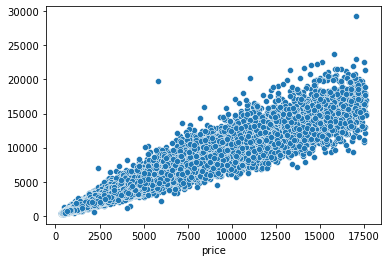

In [17]:
Linear_pipe.fit(X_train, y_train)
pred_y = Linear_pipe.predict(X_test)

true = np.expm1(y_test)
pred = np.expm1(pred_y)

#true = y_test
#pred = pred_y

print(mean_absolute_error(true, pred))
sns.scatterplot(x=true,y=pred)

In [18]:
new_x = poly.transform(test_df.drop("price", axis=1))
test_pred = np.expm1(Linear_pipe.predict(new_x))

In [19]:
test_results = pd.DataFrame({"Id" :test_df.index+1,"price": test_pred})

In [20]:
#test_results.to_csv('results.csv', index=False)